In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

In [60]:
# Define ticker symbol and start/end dates
ticker = 'TSLA'
start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

# Download historical data
stock_data = yf.download(ticker, start=start, end=end)

stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500


In [61]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1171 entries, 2020-01-02 to 2024-08-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1171 non-null   float64
 1   High       1171 non-null   float64
 2   Low        1171 non-null   float64
 3   Close      1171 non-null   float64
 4   Adj Close  1171 non-null   float64
 5   Volume     1171 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 64.0 KB


In [62]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1.171000e+03
mean,207.214809,211.871437,202.242240,207.152203,207.152203,1.282742e+08
std,80.477303,82.087297,78.574012,80.292233,80.292233,8.388763e+07
min,24.980000,26.990667,23.367332,24.081333,24.081333,2.940180e+07
25%,169.209999,174.364998,166.619995,170.119995,170.119995,7.700545e+07
50%,216.800003,221.683334,211.009995,216.520004,216.520004,1.038899e+08
75%,255.785004,260.625000,250.533333,256.509995,256.509995,1.484560e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


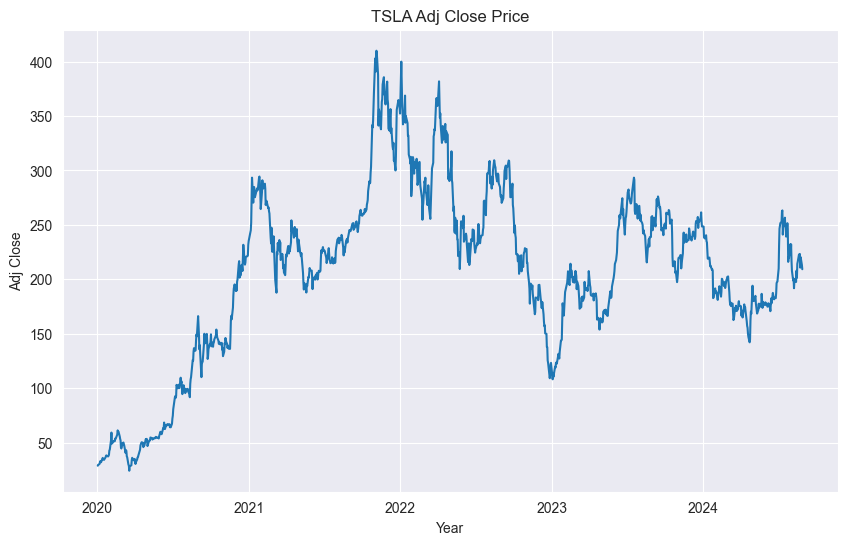

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Adj Close'])
plt.title(f"{ticker} Adj Close Price")
plt.xlabel("Year")
plt.ylabel("Adj Close")
plt.show()

In [81]:
null = stock_data.isnull().sum()
print(null)

Open                    0
High                    0
Low                     0
Close                   0
Adj Close               0
Volume                  0
Daily Return            1
Cumulative Return       1
50-Day MA              49
200-Day MA            199
Rolling Volatility     20
RSI                    13
dtype: int64


In [82]:
duplicates = stock_data.duplicated().sum()
print(duplicates)

0


In [83]:
stock_data.to_csv('stock_data.csv')

In [84]:
# Daily returns
stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()

In [85]:
# Cumulative returns
stock_data['Cumulative Return'] = (1 + stock_data['Daily Return']).cumprod()

In [86]:
# Moving averages
stock_data['50-Day MA'] = stock_data['Adj Close'].rolling(window=50).mean()
stock_data['200-Day MA'] = stock_data['Adj Close'].rolling(window=200).mean()

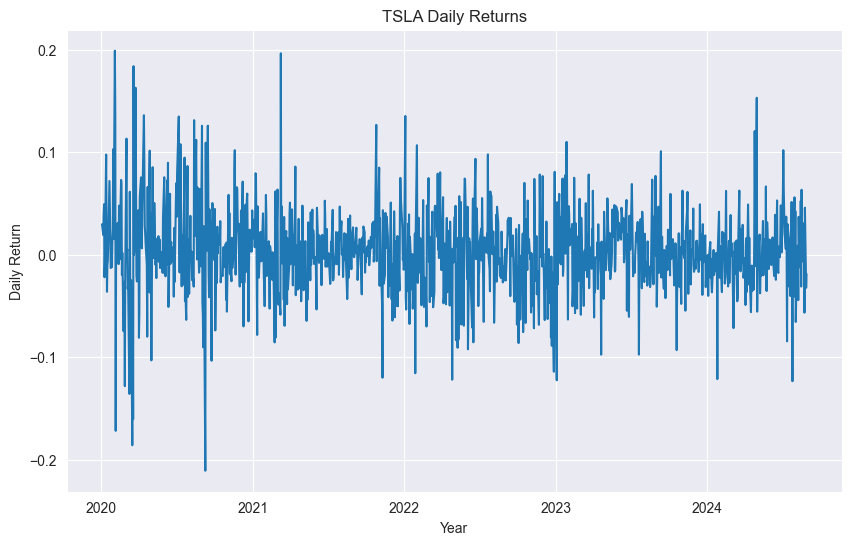

In [88]:
# Plot daily returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Daily Return'])
plt.title(f"{ticker} Daily Returns")
plt.xlabel("Year")
plt.ylabel("Daily Return")
plt.show()

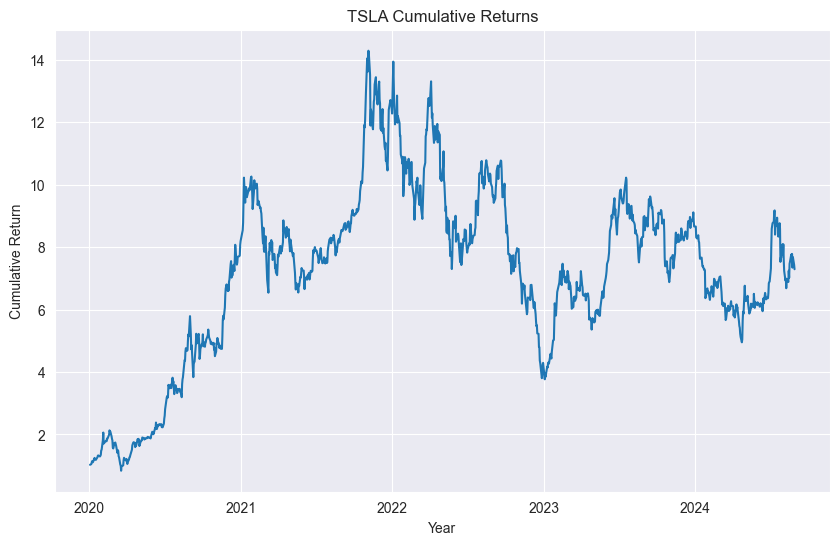

In [89]:
# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Cumulative Return'])
plt.title(f"{ticker} Cumulative Returns")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.show()

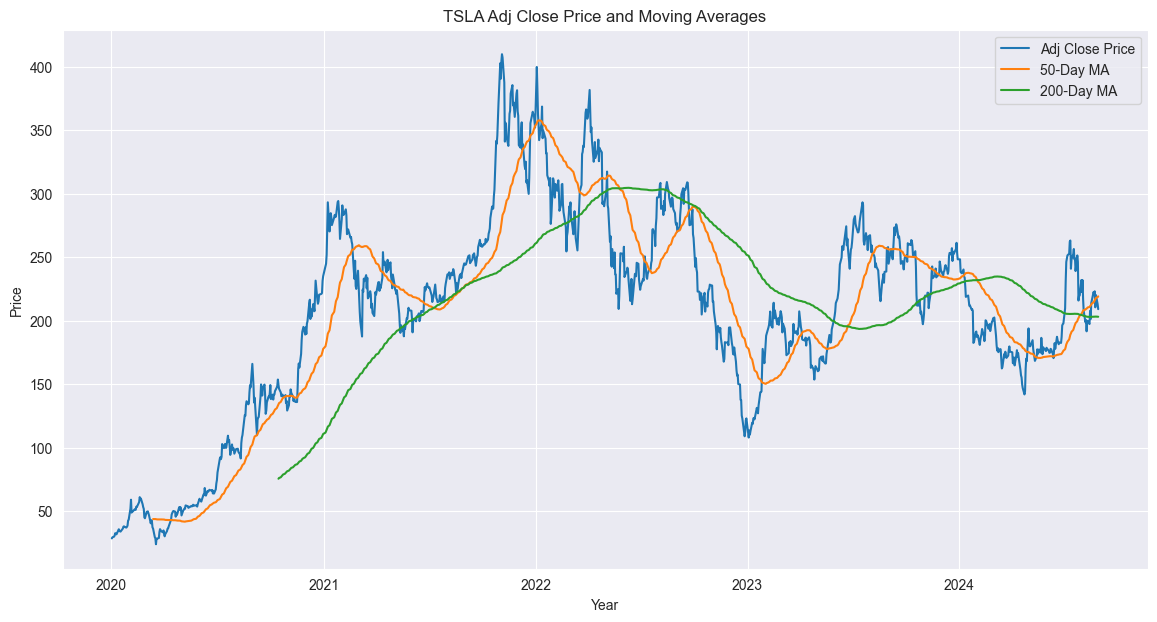

In [90]:
# Plot moving averages
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Adj Close'], label = "Adj Close Price")
plt.plot(stock_data['50-Day MA'], label="50-Day MA")
plt.plot(stock_data['200-Day MA'], label="200-Day MA")
plt.title(f"{ticker} Adj Close Price and Moving Averages")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()

In [73]:
# Identifying golden crosses
golden_cross = stock_data[(stock_data['50-Day MA'] > stock_data['200-Day MA']) & (stock_data['50-Day MA'].shift(1) <=stock_data['200-Day MA'].shift(1))]

# Identifying death crosses
death_cross = stock_data[(stock_data['50-Day MA'] < stock_data['200-Day MA']) & (stock_data['50-Day MA'].shift(1) >=stock_data['200-Day MA'].shift(1))]

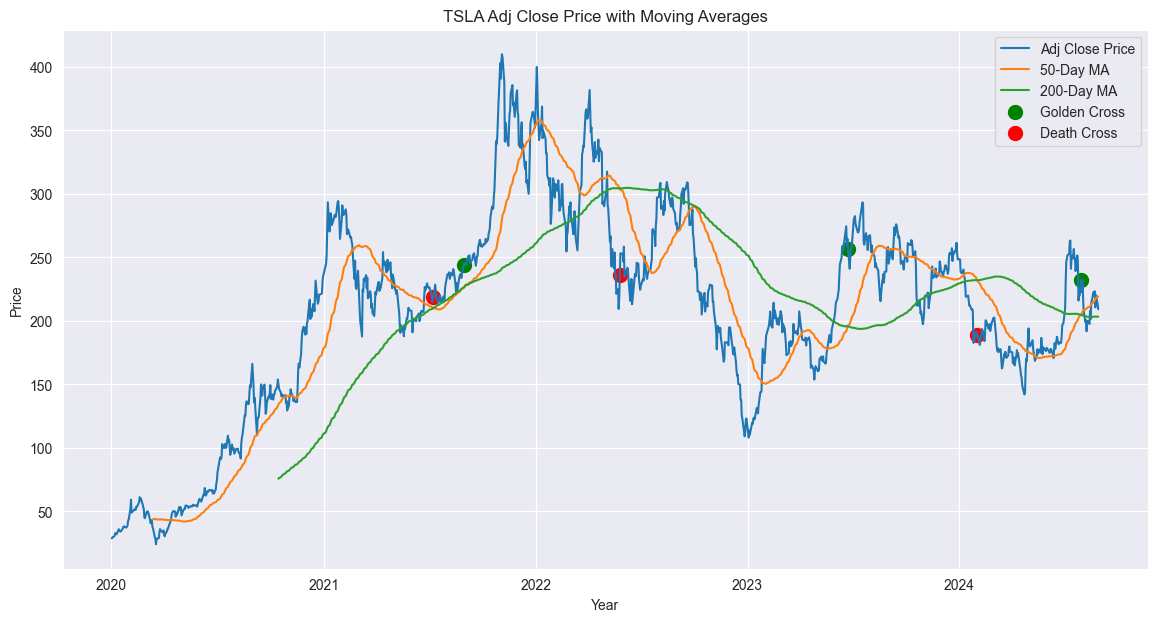

In [100]:
# Plot with markers
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Adj Close'], label = "Adj Close Price")
plt.plot(stock_data['50-Day MA'], label="50-Day MA")
plt.plot(stock_data['200-Day MA'], label="200-Day MA")

# Plot golden crosses
plt.scatter(golden_cross.index, stock_data.loc[golden_cross.index, 'Adj Close'], marker='o', color='green', s=100, label='Golden Cross')

# Plot death crosses
plt.scatter(death_cross.index, stock_data.loc[death_cross.index, 'Adj Close'], marker='o', color='red', s=100, label='Death Cross')

plt.title(f"{ticker} Adj Close Price with Moving Averages")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()

In [101]:
# Rolling volatility
stock_data['Rolling Volatility'] = stock_data['Daily Return'].rolling(window=20).std()

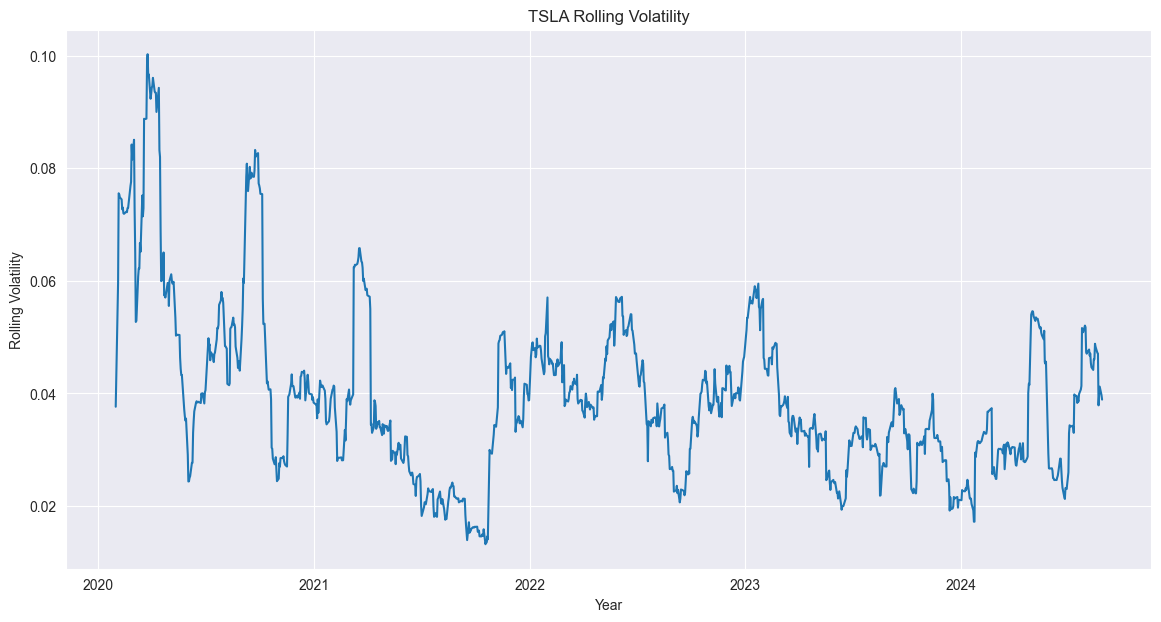

In [102]:
# Plot volatility
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Rolling Volatility'])
plt.title(f"{ticker} Rolling Volatility")
plt.xlabel("Year")
plt.ylabel("Rolling Volatility")
plt.show()

In [103]:
# Calculate relative strength index (RSI)
def RSI(data, window=14):
    change = data['Adj Close'].diff()
    gain = change.where(change > 0, 0)
    loss = -change.where(change < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    
    return RSI

stock_data['RSI'] = RSI(stock_data)

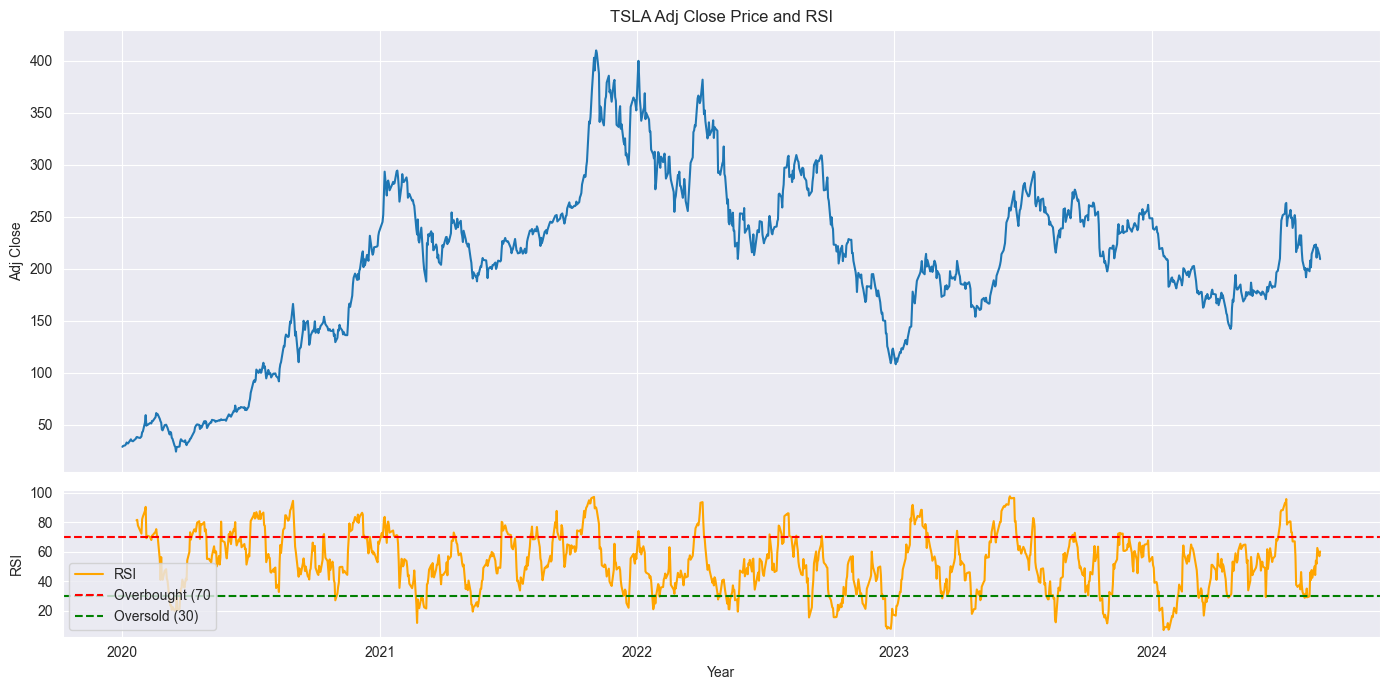

In [119]:
# Plot RSI

# Create a figure with two subplots: one for adj close price and one for RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the adj close price on the first (larger) subplot
ax1.plot(stock_data['Adj Close'])
ax1.set_title(f"{ticker} Adj Close Price and RSI")
ax1.set_ylabel("Adj Close")

# Plot RSI on the second (smaller) subplot
ax2.plot(stock_data['RSI'], label="RSI", color='orange')
ax2.axhline(70, color='red', linestyle='--', label="Overbought (70")
ax2.axhline(30, color='green', linestyle='--', label="Oversold (30)")
ax2.set_xlabel("Year")
ax2.set_ylabel("RSI")
ax2.legend()

# Improve layout
plt.tight_layout()

plt.show()